In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from decimal import Decimal
import os
from src.loader import SnapshotsLoader
from src.book import calculate_execution_prices

In [2]:
MAX_DEPTH = 20
DATA_FOLDER = 'data/'
SNAPSHOTS = 'snapshots_{instrument}_{date}.csv'
TRADES = 'trades_{instrument}_{date}.csv'

BTC_USDT = 'btc-usdt'
DATE = '20211015'

snapshots = SnapshotsLoader.get_snapshots(os.path.join(DATA_FOLDER, SNAPSHOTS.format(instrument=BTC_USDT, date=DATE)))

Successfully loaded 864253 snapshots!


In [3]:
assert np.all(snapshots.depth == MAX_DEPTH)

# Calculate the midprice & orderbook imbalance

,timestamp,update_id,market,depth,ask_prices,ask_amounts,bid_prices,bid_amounts,date,best_ask,best_bid,mid,total_bid_amount,total_ask_amount,imbalance
0,1634169600034644741,14311550913,btc-usdt,20,"[57367.01, 57370.82, 57370.84, 57370.85, 57372...","[0.00909, 0.04631, 0.00146, 0.13074, 0.06798, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.18061, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.034645,57367.01,57367,57367.005,6.51589,3.81535,0.2613955343211463483570220032
1,1634169600127002542,14311550939,btc-usdt,20,"[57367.01, 57370.84, 57370.85, 57372.38, 57373...","[0.00001, 0.00146, 0.13074, 0.06798, 0.07774, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.17774, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.127002,57367.01,57367,57367.005,6.62687,3.39309,0.3227338232887157234160615412
2,1634169600226964010,14311550983,btc-usdt,20,"[57370.84, 57370.85, 57373.92, 57374.28, 57374...","[0.08756, 0.13074, 0.07774, 0.06798, 0.14857, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.21189, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.226964,57370.84,57370.83,57370.835,5.86723,3.63086,0.2354547072095547631155316490
3,1634169600326794942,14311550994,btc-usdt,20,"[57370.84, 57370.85, 57373.92, 57374.28, 57374...","[0.55557, 0.13074, 0.07774, 0.06798, 0.14857, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.24189, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.326795,57370.84,57370.83,57370.835,6.20399,4.30470,0.1807351820255426699236536619
4,1634169600426930803,14311551001,btc-usdt,20,"[57370.84, 57370.85, 57373.91, 57373.92, 57374...","[0.55315, 0.13074, 0.14883, 0.07774, 0.06798, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.24154, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.426931,57370.84,57370.83,57370.835,6.05621,4.37328,0.1613626361404057149486695898


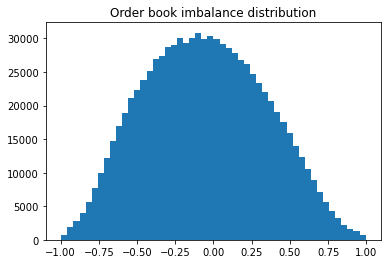

In [4]:
snapshots['mid'] = (snapshots.best_ask + snapshots.best_bid) / 2
snapshots['total_bid_amount'] = snapshots.bid_amounts.apply(sum)
snapshots['total_ask_amount'] = snapshots.ask_amounts.apply(sum)
snapshots['imbalance'] = (snapshots.total_bid_amount - snapshots.total_ask_amount) / (snapshots.total_bid_amount + snapshots.total_ask_amount)

plt.hist(snapshots.imbalance, bins=50)
plt.title('Order book imbalance distribution')
snapshots.head()

In [5]:
snapshots.imbalance.mean(), snapshots.imbalance.median()

(-0.05491183647331868, -0.06405462670030147)

There were more sellers during that day.

# Aggregate the data to 1 minute orderbook summaries

In [6]:
snapshots_minutes = snapshots.groupby(by=snapshots.date.dt.floor('T'))[['mid', 'imbalance']].mean()

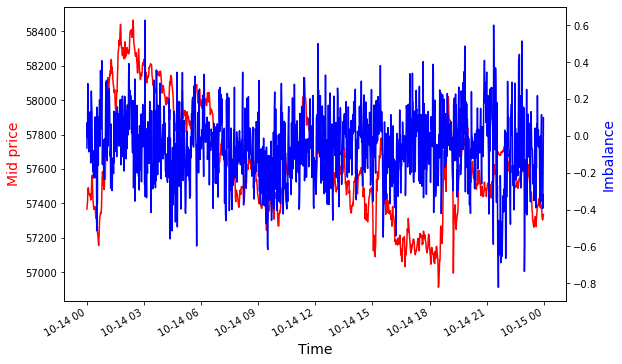

In [18]:
def plot_mid_and_imbalance(df):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(df.index, df.mid, color="red")
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Mid price", color="red", fontsize=14)

    ax2 = ax.twinx()
    ax2.plot(df.index, df.imbalance, color="blue")
    ax2.set_ylabel("Imbalance", color="blue", fontsize=14)
    fig.autofmt_xdate()

plot_mid_and_imbalance(snapshots_minutes)

# Calculate the mean of the mid price & orderbook imbalance with a rolling window of  1 hour

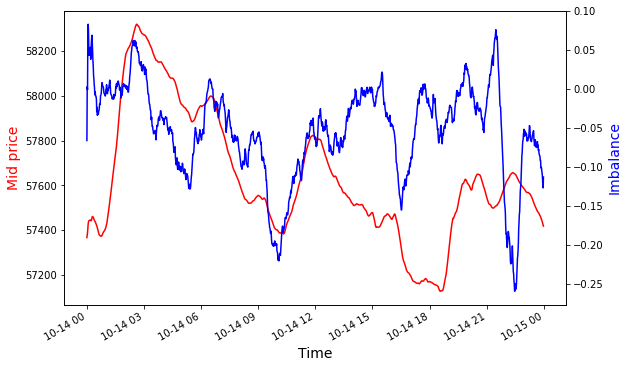

In [19]:
snapshots_ma60 = snapshots_minutes.rolling(60, min_periods=1).mean()
plot_mid_and_imbalance(snapshots_ma60)

This chart is more readable than 1 minute summaries. It looks like the peaks of both charts usually coincide. When imbalance becomes too high or too low, the trend changes. 

In [9]:
snapshots_ma60.corr()

,mid,imbalance
mid,1.000000,0.187108
imbalance,0.187108,1.000000


# Calculate the immediate average market impact of a market buy and sell order

In [20]:
volumes = np.array([1000, 10000, 50000, 100000, 1000000])
print(volumes)
ask_volume_median = snapshots.total_ask_amount.median() * snapshots.mid.mean()
bid_volume_median = snapshots.total_bid_amount.median() * snapshots.mid.mean()
print(f'Median ask and bid volumes in the book are: {ask_volume_median:.0f}, {bid_volume_median:.0f}.')

[   1000   10000   50000  100000 1000000]
Median ask and bid volumes in the book are: 222614, 195116.


The exact analysis for volume 1000000 is problematic since there are not enough orders in 20 levels of the book, we can only draw some estimations. We can conclude that the slippage of the execution of such an order is very big.

Books in which there are not enough orders are problematic for calculations. I see 3 possible workarounds:
1. Drop all rows with thin order books.
2. If there are not enough orders, increase the amount on the 20th level of the book. Since the results of this method will be between results of methods 1 and 3, I am not going to implement it.
3. Interpolate the execution price given the execution price of the first 20 levels.

In [11]:
def find_impacts(df, volumes):
    buy_average_price = df.apply(lambda row: calculate_execution_prices(row.mid, row.ask_prices, row.ask_amounts, volumes), axis=1)
    buy_impacts = (buy_average_price / df.mid) - 1
    
    sell_average_price = df.apply(lambda row: calculate_execution_prices(row.mid, row.bid_prices, row.bid_amounts, volumes), axis=1)
    sell_impacts = (sell_average_price / df.mid) - 1
    return buy_impacts.mean() * 100, sell_impacts.mean() * 100

In [12]:
# Let's drop books with less than 2 bitcoins on each side. That would be sufficient to trade all the volumes except for the last.
buy_impacts_dropped, sell_impacts_dropped = find_impacts(snapshots[np.logical_and(snapshots.total_ask_amount > 2, snapshots.total_bid_amount > 2)], volumes[:-1])

buy_impacts_approx, sell_impacts_approx = find_impacts(snapshots, volumes)

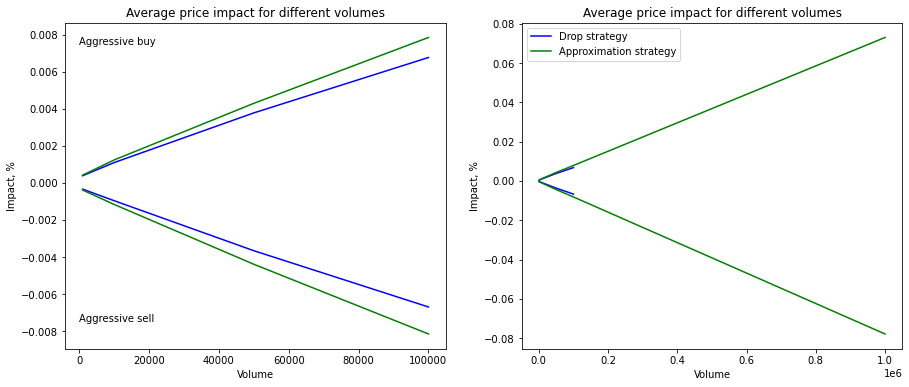

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, ax in enumerate(axes): 
    ax.set_title('Average price impact for different volumes')
    ax.plot(volumes[:-1], buy_impacts_dropped, c='blue', label='Drop strategy')
    ax.plot(volumes[:-1], sell_impacts_dropped, c='blue')
    
    if i == 0:
        ax.plot(volumes[:-1], buy_impacts_approx[:-1], c='green', label='Approximation strategy')
        ax.plot(volumes[:-1], sell_impacts_approx[:-1], c='green')
        
        ax.text(0.1, 0.0075, "Aggressive buy")
        ax.text(0.1, -0.0075, "Aggressive sell")
    else:
        ax.plot(volumes, buy_impacts_approx, c='green', label='Approximation strategy')
        ax.plot(volumes, sell_impacts_approx, c='green')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Impact, %')

plt.legend();

There is a clear linear dependency between the volume and the market impact in the first chart. Both strategies give similar results, which means we can trust these values.

However, for orders with a volume 1.000.000 drop strategy is not applicable because we need to drop more than half of the points. We can not expect precise values from the approximation strategy either.

In [14]:
trades = pd.read_csv(os.path.join(DATA_FOLDER, TRADES.format(instrument=BTC_USDT, date=DATE)))
grouped_trades = trades.groupby(by='timestamp')['amount'].sum()

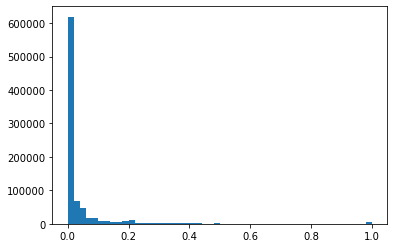

In [15]:
plt.hist(np.clip(grouped_trades, 0, 1), bins=50);

In [16]:
print(f'Number of trades with amount > 1: {(grouped_trades > 1).sum()}')

Number of trades with amount > 1: 5030


In [42]:
pd.merge_asof(trades, snapshots, on='timestamp', direction='backward')

,timestamp,id,market_x,price,amount,buyer_maker,best_match,date_x,price*amount,update_id,...,ask_amounts,bid_prices,bid_amounts,date_y,best_ask,best_bid,mid,total_bid_amount,total_ask_amount,imbalance
0,1634169600001000000,1095844216,btc-usdt,57370.83,0.00150,True,True,2021-10-14 00:00:00.001,86.056245,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,1634169600005000000,1095844217,btc-usdt,57370.84,0.00060,False,True,2021-10-14 00:00:00.005,34.422504,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,1634169600221000000,1095844218,btc-usdt,57370.84,0.00041,False,True,2021-10-14 00:00:00.221,23.522044,1.431155e+10,...,"[0.00001, 0.00146, 0.13074, 0.06798, 0.07774, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.17774, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.127002,57367.01,57367,57367.005,6.62687,3.39309,0.3227338232887157234160615412
3,1634169600221000000,1095844219,btc-usdt,57370.84,0.00219,False,True,2021-10-14 00:00:00.221,125.642140,1.431155e+10,...,"[0.00001, 0.00146, 0.13074, 0.06798, 0.07774, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.17774, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.127002,57367.01,57367,57367.005,6.62687,3.39309,0.3227338232887157234160615412
4,1634169600237000000,1095844220,btc-usdt,57370.83,0.00035,True,True,2021-10-14 00:00:00.237,20.079791,1.431155e+10,...,"[0.08756, 0.13074, 0.07774, 0.06798, 0.14857, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.21189, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.226964,57370.84,57370.83,57370.835,5.86723,3.63086,0.2354547072095547631155316490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372045,1634255999975000000,1097216259,btc-usdt,57347.94,0.00063,True,True,2021-10-14 23:59:59.975,36.129202,1.433538e+10,...,"[0.84007, 0.01161, 0.01162, 0.0436, 0.62834, 0...","[57347.94, 57345.02, 57344.99, 57343.24, 57342...","[0.01063, 0.03734, 0.0988, 0.00434, 0.03127, 0...",2021-10-14 23:59:59.898599,57347.95,57347.94,57347.945,3.58373,3.33239,0.03634118552020497041693897735
1372046,1634255999976000000,1097216260,btc-usdt,57347.95,0.00123,False,True,2021-10-14 23:59:59.976,70.537978,1.433538e+10,...,"[0.84007, 0.01161, 0.01162, 0.0436, 0.62834, 0...","[57347.94, 57345.02, 57344.99, 57343.24, 57342...","[0.01063, 0.03734, 0.0988, 0.00434, 0.03127, 0...",2021-10-14 23:59:59.898599,57347.95,57347.94,57347.945,3.58373,3.33239,0.03634118552020497041693897735
1372047,1634255999990000000,1097216262,btc-usdt,57347.95,0.00099,False,True,2021-10-14 23:59:59.990,56.774470,1.433538e+10,...,"[0.84007, 0.01161, 0.01162, 0.0436, 0.62834, 0...","[57347.94, 57345.02, 57344.99, 57343.24, 57342...","[0.01063, 0.03734, 0.0988, 0.00434, 0.03127, 0...",2021-10-14 23:59:59.898599,57347.95,57347.94,57347.945,3.58373,3.33239,0.03634118552020497041693897735
1372048,1634255999990000000,1097216261,btc-usdt,57347.94,0.00038,True,True,2021-10-14 23:59:59.990,21.792217,1.433538e+10,...,"[0.84007, 0.01161, 0.01162, 0.0436, 0.62834, 0...","[57347.94, 57345.02, 57344.99, 57343.24, 57342...","[0.01063, 0.03734, 0.0988, 0.00434, 0.03127, 0...",2021-10-14 23:59:59.898599,57347.95,57347.94,57347.945,3.58373,3.33239,0.03634118552020497041693897735
